In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_grids = np.load('data/sudoku_train_grids.npy')
train_grids_labels = np.load('data/sudoku_train_grids_labels.npy')

train_grids = train_grids.astype("float32")
train_grids_labels = train_grids_labels.astype("float32")

In [3]:
train_grids.shape

(50000, 9, 9)

In [4]:
train_grids_labels.shape

(50000, 9, 9)

In [5]:
train_grids = train_grids.reshape(-1,1,9,9)
train_grids_labels = train_grids_labels.reshape(-1,81,1) - 1 

In [6]:
sudoku_grids = torch.tensor(train_grids) #converting to tensors
sudoku_grids_labels = torch.tensor(train_grids_labels)

test_size = 0.2

num_test_samples = int(len(sudoku_grids) * test_size)

# Shuffling the dataset
indices = np.arange(len(sudoku_grids))
np.random.shuffle(indices)

train_indices , test_indices = indices[num_test_samples:] , indices[:num_test_samples]

# splitting into train and test 
X_train, y_train = sudoku_grids[train_indices] , sudoku_grids_labels[train_indices]
X_test, y_test= sudoku_grids[test_indices] , sudoku_grids_labels[test_indices]

In [7]:
class SudokuDataset(Dataset):
    def __init__(self,data , labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample , label

In [8]:
# Creating the training set and the validation set based on our train and test split
train_set = SudokuDataset(X_train , y_train)
val_set = SudokuDataset(X_test , y_test)

criterion = nn.CrossEntropyLoss()

In [9]:
# Creating a training loop with train and validation loops 
def train_model(model, train_loader, test_loader, epochs):
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        # Training Phase
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1} Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1).long())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct = (predicted == labels.view(-1)).sum().item()
            train_correct += (correct / labels.view(-1).size(0)) * labels.size(0)
            total_train += labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / total_train

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch + 1} Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels.view(-1).long()).item()

                _, predicted = torch.max(outputs, dim=1)
                correct = (predicted == labels.view(-1)).sum().item()
                val_correct += (correct / labels.view(-1).size(0)) * labels.size(0)
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = val_correct / total_val

        losses['train'].append(avg_train_loss)
        losses['val'].append(avg_val_loss)
        accuracies['train'].append(train_accuracy)
        accuracies['val'].append(val_accuracy)

        print(f'Epoch {epoch + 1}: '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')
    # Plot loss and accuracy curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses['train'], label='Train Loss')
    plt.plot(losses['val'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies['train'], label='Train Accuracy')
    plt.plot(accuracies['val'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Fully Connected Network

In [ ]:
class SudokuSolverANN(nn.Module):
    def __init__(self,dropout_rate = 0.2):
        super(SudokuSolverANN, self).__init__()
        self.fc1 = nn.Linear(9 * 9, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc4 = nn.Linear(1024, 81 * 9)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x.view(-1, 9)
        
model = SudokuSolverANN(dropout_rate =0.2)
model.to(device) # moving to the device gpu

In [11]:
model

SudokuSolverANN(
  (fc1): Linear(in_features=81, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=1024, out_features=729, bias=True)
)

Epoch 1 Validation: 100%|██████████| 313/313 [00:00<00:00, 741.98it/s]


Epoch 1: Train Loss: 2.1600, Train Accuracy: 0.1557, Validation Loss: 2.1064, Validation Accuracy: 0.1684


Epoch 2 Validation: 100%|██████████| 313/313 [00:00<00:00, 857.70it/s]


Epoch 2: Train Loss: 2.0807, Train Accuracy: 0.1837, Validation Loss: 2.0713, Validation Accuracy: 0.1792


Epoch 3 Validation: 100%|██████████| 313/313 [00:00<00:00, 864.57it/s]


Epoch 3: Train Loss: 2.0283, Train Accuracy: 0.2042, Validation Loss: 2.0124, Validation Accuracy: 0.2004


Epoch 4 Validation: 100%|██████████| 313/313 [00:00<00:00, 839.10it/s]


Epoch 4: Train Loss: 1.9719, Train Accuracy: 0.2249, Validation Loss: 1.9601, Validation Accuracy: 0.2194


Epoch 5 Validation: 100%|██████████| 313/313 [00:00<00:00, 825.70it/s]


Epoch 5: Train Loss: 1.9289, Train Accuracy: 0.2427, Validation Loss: 1.9253, Validation Accuracy: 0.2347


Epoch 6 Validation: 100%|██████████| 313/313 [00:00<00:00, 849.93it/s]


Epoch 6: Train Loss: 1.8971, Train Accuracy: 0.2571, Validation Loss: 1.8999, Validation Accuracy: 0.2466


Epoch 7 Validation: 100%|██████████| 313/313 [00:00<00:00, 848.76it/s]


Epoch 7: Train Loss: 1.8704, Train Accuracy: 0.2692, Validation Loss: 1.8793, Validation Accuracy: 0.2566


Epoch 8 Validation: 100%|██████████| 313/313 [00:00<00:00, 837.83it/s]


Epoch 8: Train Loss: 1.8487, Train Accuracy: 0.2793, Validation Loss: 1.8620, Validation Accuracy: 0.2651


Epoch 9 Validation: 100%|██████████| 313/313 [00:00<00:00, 863.77it/s]


Epoch 9: Train Loss: 1.8283, Train Accuracy: 0.2889, Validation Loss: 1.8461, Validation Accuracy: 0.2730


Epoch 10 Validation: 100%|██████████| 313/313 [00:00<00:00, 822.20it/s]


Epoch 10: Train Loss: 1.8110, Train Accuracy: 0.2969, Validation Loss: 1.8311, Validation Accuracy: 0.2801


Epoch 11 Validation: 100%|██████████| 313/313 [00:00<00:00, 848.69it/s]


Epoch 11: Train Loss: 1.7938, Train Accuracy: 0.3044, Validation Loss: 1.8175, Validation Accuracy: 0.2874


Epoch 12 Validation: 100%|██████████| 313/313 [00:00<00:00, 832.54it/s]


Epoch 12: Train Loss: 1.7786, Train Accuracy: 0.3109, Validation Loss: 1.8061, Validation Accuracy: 0.2919


Epoch 13 Validation: 100%|██████████| 313/313 [00:00<00:00, 853.70it/s]


Epoch 13: Train Loss: 1.7649, Train Accuracy: 0.3175, Validation Loss: 1.7934, Validation Accuracy: 0.2993


Epoch 14 Validation: 100%|██████████| 313/313 [00:00<00:00, 786.20it/s]


Epoch 14: Train Loss: 1.7505, Train Accuracy: 0.3237, Validation Loss: 1.7811, Validation Accuracy: 0.3048


Epoch 15 Validation: 100%|██████████| 313/313 [00:00<00:00, 875.53it/s]


Epoch 15: Train Loss: 1.7393, Train Accuracy: 0.3282, Validation Loss: 1.7708, Validation Accuracy: 0.3093


Epoch 16 Validation: 100%|██████████| 313/313 [00:00<00:00, 829.16it/s]


Epoch 16: Train Loss: 1.7276, Train Accuracy: 0.3335, Validation Loss: 1.7591, Validation Accuracy: 0.3163


Epoch 17 Validation: 100%|██████████| 313/313 [00:00<00:00, 845.04it/s]


Epoch 17: Train Loss: 1.7185, Train Accuracy: 0.3372, Validation Loss: 1.7508, Validation Accuracy: 0.3197


Epoch 18 Validation: 100%|██████████| 313/313 [00:00<00:00, 842.25it/s]


Epoch 18: Train Loss: 1.7084, Train Accuracy: 0.3413, Validation Loss: 1.7412, Validation Accuracy: 0.3234


Epoch 19 Validation: 100%|██████████| 313/313 [00:00<00:00, 834.73it/s]


Epoch 19: Train Loss: 1.6996, Train Accuracy: 0.3452, Validation Loss: 1.7330, Validation Accuracy: 0.3284


Epoch 20 Validation: 100%|██████████| 313/313 [00:00<00:00, 833.67it/s]


Epoch 20: Train Loss: 1.6902, Train Accuracy: 0.3494, Validation Loss: 1.7223, Validation Accuracy: 0.3332


Epoch 21 Validation: 100%|██████████| 313/313 [00:00<00:00, 866.33it/s]


Epoch 21: Train Loss: 1.6828, Train Accuracy: 0.3524, Validation Loss: 1.7148, Validation Accuracy: 0.3372


Epoch 22 Validation: 100%|██████████| 313/313 [00:00<00:00, 833.35it/s]


Epoch 22: Train Loss: 1.6738, Train Accuracy: 0.3565, Validation Loss: 1.7066, Validation Accuracy: 0.3408


Epoch 23 Validation: 100%|██████████| 313/313 [00:00<00:00, 831.82it/s]


Epoch 23: Train Loss: 1.6692, Train Accuracy: 0.3580, Validation Loss: 1.6990, Validation Accuracy: 0.3448


Epoch 24 Validation: 100%|██████████| 313/313 [00:00<00:00, 868.76it/s]


Epoch 24: Train Loss: 1.6613, Train Accuracy: 0.3618, Validation Loss: 1.6908, Validation Accuracy: 0.3490


Epoch 25 Validation: 100%|██████████| 313/313 [00:00<00:00, 841.33it/s]


Epoch 25: Train Loss: 1.6538, Train Accuracy: 0.3646, Validation Loss: 1.6849, Validation Accuracy: 0.3513


Epoch 26 Validation: 100%|██████████| 313/313 [00:00<00:00, 862.22it/s]


Epoch 26: Train Loss: 1.6484, Train Accuracy: 0.3669, Validation Loss: 1.6779, Validation Accuracy: 0.3550


Epoch 27 Validation: 100%|██████████| 313/313 [00:00<00:00, 844.91it/s]


Epoch 27: Train Loss: 1.6409, Train Accuracy: 0.3702, Validation Loss: 1.6683, Validation Accuracy: 0.3602


Epoch 28 Validation: 100%|██████████| 313/313 [00:00<00:00, 831.91it/s]


Epoch 28: Train Loss: 1.6348, Train Accuracy: 0.3727, Validation Loss: 1.6599, Validation Accuracy: 0.3646


Epoch 29 Validation: 100%|██████████| 313/313 [00:00<00:00, 849.50it/s]


Epoch 29: Train Loss: 1.6290, Train Accuracy: 0.3748, Validation Loss: 1.6548, Validation Accuracy: 0.3660


Epoch 30 Validation: 100%|██████████| 313/313 [00:00<00:00, 856.41it/s]


Epoch 30: Train Loss: 1.6224, Train Accuracy: 0.3775, Validation Loss: 1.6480, Validation Accuracy: 0.3688


Epoch 31 Validation: 100%|██████████| 313/313 [00:00<00:00, 828.75it/s]


Epoch 31: Train Loss: 1.6182, Train Accuracy: 0.3797, Validation Loss: 1.6406, Validation Accuracy: 0.3733


Epoch 32 Validation: 100%|██████████| 313/313 [00:00<00:00, 834.29it/s]


Epoch 32: Train Loss: 1.6126, Train Accuracy: 0.3816, Validation Loss: 1.6354, Validation Accuracy: 0.3748


Epoch 33 Validation: 100%|██████████| 313/313 [00:00<00:00, 734.34it/s]


Epoch 33: Train Loss: 1.6062, Train Accuracy: 0.3842, Validation Loss: 1.6278, Validation Accuracy: 0.3786


Epoch 34 Validation: 100%|██████████| 313/313 [00:00<00:00, 816.80it/s]


Epoch 34: Train Loss: 1.6025, Train Accuracy: 0.3856, Validation Loss: 1.6218, Validation Accuracy: 0.3811


Epoch 35 Validation: 100%|██████████| 313/313 [00:00<00:00, 837.67it/s]


Epoch 35: Train Loss: 1.5975, Train Accuracy: 0.3878, Validation Loss: 1.6148, Validation Accuracy: 0.3839


Epoch 36 Validation: 100%|██████████| 313/313 [00:00<00:00, 848.34it/s]


Epoch 36: Train Loss: 1.5926, Train Accuracy: 0.3894, Validation Loss: 1.6091, Validation Accuracy: 0.3868


Epoch 37 Validation: 100%|██████████| 313/313 [00:00<00:00, 846.84it/s]


Epoch 37: Train Loss: 1.5872, Train Accuracy: 0.3918, Validation Loss: 1.6024, Validation Accuracy: 0.3899


Epoch 38 Validation: 100%|██████████| 313/313 [00:00<00:00, 821.74it/s]


Epoch 38: Train Loss: 1.5823, Train Accuracy: 0.3941, Validation Loss: 1.5968, Validation Accuracy: 0.3931


Epoch 39 Validation: 100%|██████████| 313/313 [00:00<00:00, 840.17it/s]


Epoch 39: Train Loss: 1.5778, Train Accuracy: 0.3955, Validation Loss: 1.5901, Validation Accuracy: 0.3963


Epoch 40 Validation: 100%|██████████| 313/313 [00:00<00:00, 826.17it/s]


Epoch 40: Train Loss: 1.5736, Train Accuracy: 0.3969, Validation Loss: 1.5835, Validation Accuracy: 0.3989


Epoch 41 Validation: 100%|██████████| 313/313 [00:00<00:00, 821.06it/s]


Epoch 41: Train Loss: 1.5700, Train Accuracy: 0.3985, Validation Loss: 1.5793, Validation Accuracy: 0.4008


Epoch 42 Validation: 100%|██████████| 313/313 [00:00<00:00, 855.09it/s]


Epoch 42: Train Loss: 1.5653, Train Accuracy: 0.4003, Validation Loss: 1.5731, Validation Accuracy: 0.4035


Epoch 43 Validation: 100%|██████████| 313/313 [00:00<00:00, 830.41it/s]


Epoch 43: Train Loss: 1.5606, Train Accuracy: 0.4021, Validation Loss: 1.5686, Validation Accuracy: 0.4054


Epoch 44 Validation: 100%|██████████| 313/313 [00:00<00:00, 803.59it/s]


Epoch 44: Train Loss: 1.5587, Train Accuracy: 0.4030, Validation Loss: 1.5637, Validation Accuracy: 0.4072


Epoch 45 Validation: 100%|██████████| 313/313 [00:00<00:00, 848.47it/s]


Epoch 45: Train Loss: 1.5546, Train Accuracy: 0.4048, Validation Loss: 1.5595, Validation Accuracy: 0.4097


Epoch 46 Validation: 100%|██████████| 313/313 [00:00<00:00, 846.20it/s]


Epoch 46: Train Loss: 1.5495, Train Accuracy: 0.4065, Validation Loss: 1.5550, Validation Accuracy: 0.4107


Epoch 47 Validation: 100%|██████████| 313/313 [00:00<00:00, 841.02it/s]


Epoch 47: Train Loss: 1.5470, Train Accuracy: 0.4074, Validation Loss: 1.5492, Validation Accuracy: 0.4133


Epoch 48 Validation: 100%|██████████| 313/313 [00:00<00:00, 828.25it/s]


Epoch 48: Train Loss: 1.5444, Train Accuracy: 0.4085, Validation Loss: 1.5453, Validation Accuracy: 0.4157


Epoch 49 Validation: 100%|██████████| 313/313 [00:00<00:00, 855.98it/s]


Epoch 49: Train Loss: 1.5396, Train Accuracy: 0.4103, Validation Loss: 1.5386, Validation Accuracy: 0.4197


Epoch 50 Validation: 100%|██████████| 313/313 [00:00<00:00, 856.89it/s]


Epoch 50: Train Loss: 1.5382, Train Accuracy: 0.4107, Validation Loss: 1.5364, Validation Accuracy: 0.4197


Epoch 51 Validation: 100%|██████████| 313/313 [00:00<00:00, 856.49it/s]


Epoch 51: Train Loss: 1.5334, Train Accuracy: 0.4125, Validation Loss: 1.5318, Validation Accuracy: 0.4221


Epoch 52 Validation: 100%|██████████| 313/313 [00:00<00:00, 846.70it/s]


Epoch 52: Train Loss: 1.5316, Train Accuracy: 0.4131, Validation Loss: 1.5289, Validation Accuracy: 0.4233


Epoch 53 Validation: 100%|██████████| 313/313 [00:00<00:00, 838.14it/s]


Epoch 53: Train Loss: 1.5284, Train Accuracy: 0.4148, Validation Loss: 1.5239, Validation Accuracy: 0.4252


Epoch 54 Validation: 100%|██████████| 313/313 [00:00<00:00, 876.44it/s]


Epoch 54: Train Loss: 1.5224, Train Accuracy: 0.4171, Validation Loss: 1.5182, Validation Accuracy: 0.4281


Epoch 55 Validation: 100%|██████████| 313/313 [00:00<00:00, 804.15it/s]


Epoch 55: Train Loss: 1.5226, Train Accuracy: 0.4168, Validation Loss: 1.5153, Validation Accuracy: 0.4293


Epoch 56 Validation: 100%|██████████| 313/313 [00:00<00:00, 823.97it/s]


Epoch 56: Train Loss: 1.5185, Train Accuracy: 0.4182, Validation Loss: 1.5119, Validation Accuracy: 0.4302


Epoch 57 Validation: 100%|██████████| 313/313 [00:00<00:00, 832.34it/s]


Epoch 57: Train Loss: 1.5158, Train Accuracy: 0.4192, Validation Loss: 1.5084, Validation Accuracy: 0.4323


Epoch 58 Validation: 100%|██████████| 313/313 [00:00<00:00, 681.67it/s]


Epoch 58: Train Loss: 1.5130, Train Accuracy: 0.4211, Validation Loss: 1.5046, Validation Accuracy: 0.4341


Epoch 59 Validation: 100%|██████████| 313/313 [00:00<00:00, 859.25it/s]


Epoch 59: Train Loss: 1.5096, Train Accuracy: 0.4218, Validation Loss: 1.5023, Validation Accuracy: 0.4347


Epoch 60 Validation: 100%|██████████| 313/313 [00:00<00:00, 815.46it/s]


Epoch 60: Train Loss: 1.5085, Train Accuracy: 0.4225, Validation Loss: 1.4981, Validation Accuracy: 0.4368


Epoch 61 Validation: 100%|██████████| 313/313 [00:00<00:00, 848.86it/s]


Epoch 61: Train Loss: 1.5035, Train Accuracy: 0.4247, Validation Loss: 1.4957, Validation Accuracy: 0.4379


Epoch 62 Validation: 100%|██████████| 313/313 [00:00<00:00, 838.30it/s]


Epoch 62: Train Loss: 1.5019, Train Accuracy: 0.4247, Validation Loss: 1.4916, Validation Accuracy: 0.4403


Epoch 63 Validation: 100%|██████████| 313/313 [00:00<00:00, 857.75it/s]


Epoch 63: Train Loss: 1.5006, Train Accuracy: 0.4255, Validation Loss: 1.4882, Validation Accuracy: 0.4407


Epoch 64 Validation: 100%|██████████| 313/313 [00:00<00:00, 830.16it/s]


Epoch 64: Train Loss: 1.4970, Train Accuracy: 0.4269, Validation Loss: 1.4857, Validation Accuracy: 0.4432


Epoch 65 Validation: 100%|██████████| 313/313 [00:00<00:00, 820.54it/s]


Epoch 65: Train Loss: 1.4954, Train Accuracy: 0.4275, Validation Loss: 1.4823, Validation Accuracy: 0.4444


Epoch 66 Validation: 100%|██████████| 313/313 [00:00<00:00, 851.83it/s]


Epoch 66: Train Loss: 1.4927, Train Accuracy: 0.4284, Validation Loss: 1.4772, Validation Accuracy: 0.4477


Epoch 67 Validation: 100%|██████████| 313/313 [00:00<00:00, 842.33it/s]


Epoch 67: Train Loss: 1.4893, Train Accuracy: 0.4298, Validation Loss: 1.4758, Validation Accuracy: 0.4464


Epoch 68 Validation: 100%|██████████| 313/313 [00:00<00:00, 835.94it/s]


Epoch 68: Train Loss: 1.4893, Train Accuracy: 0.4301, Validation Loss: 1.4720, Validation Accuracy: 0.4488


Epoch 69 Validation: 100%|██████████| 313/313 [00:00<00:00, 836.63it/s]


Epoch 69: Train Loss: 1.4863, Train Accuracy: 0.4311, Validation Loss: 1.4713, Validation Accuracy: 0.4489


Epoch 70 Validation: 100%|██████████| 313/313 [00:00<00:00, 825.38it/s]


Epoch 70: Train Loss: 1.4849, Train Accuracy: 0.4313, Validation Loss: 1.4690, Validation Accuracy: 0.4504


Epoch 71 Validation: 100%|██████████| 313/313 [00:00<00:00, 825.55it/s]


Epoch 71: Train Loss: 1.4819, Train Accuracy: 0.4330, Validation Loss: 1.4649, Validation Accuracy: 0.4529


Epoch 72 Validation: 100%|██████████| 313/313 [00:00<00:00, 870.20it/s]


Epoch 72: Train Loss: 1.4784, Train Accuracy: 0.4339, Validation Loss: 1.4630, Validation Accuracy: 0.4530


Epoch 73 Validation: 100%|██████████| 313/313 [00:00<00:00, 791.28it/s]


Epoch 73: Train Loss: 1.4786, Train Accuracy: 0.4338, Validation Loss: 1.4603, Validation Accuracy: 0.4537


Epoch 74 Validation: 100%|██████████| 313/313 [00:00<00:00, 814.00it/s]


Epoch 74: Train Loss: 1.4761, Train Accuracy: 0.4352, Validation Loss: 1.4565, Validation Accuracy: 0.4564


Epoch 75 Validation: 100%|██████████| 313/313 [00:00<00:00, 860.45it/s]


Epoch 75: Train Loss: 1.4741, Train Accuracy: 0.4359, Validation Loss: 1.4552, Validation Accuracy: 0.4555


Epoch 76 Validation: 100%|██████████| 313/313 [00:00<00:00, 817.03it/s]


Epoch 76: Train Loss: 1.4724, Train Accuracy: 0.4363, Validation Loss: 1.4520, Validation Accuracy: 0.4584


Epoch 77 Validation: 100%|██████████| 313/313 [00:00<00:00, 834.82it/s]


Epoch 77: Train Loss: 1.4680, Train Accuracy: 0.4383, Validation Loss: 1.4514, Validation Accuracy: 0.4575


Epoch 78 Validation: 100%|██████████| 313/313 [00:00<00:00, 781.24it/s]


Epoch 78: Train Loss: 1.4674, Train Accuracy: 0.4383, Validation Loss: 1.4476, Validation Accuracy: 0.4598


Epoch 79 Validation: 100%|██████████| 313/313 [00:00<00:00, 846.72it/s]


Epoch 79: Train Loss: 1.4657, Train Accuracy: 0.4392, Validation Loss: 1.4451, Validation Accuracy: 0.4618


Epoch 80 Validation: 100%|██████████| 313/313 [00:00<00:00, 865.58it/s]


Epoch 80: Train Loss: 1.4640, Train Accuracy: 0.4398, Validation Loss: 1.4436, Validation Accuracy: 0.4619


Epoch 81 Validation: 100%|██████████| 313/313 [00:00<00:00, 834.38it/s]


Epoch 81: Train Loss: 1.4630, Train Accuracy: 0.4402, Validation Loss: 1.4418, Validation Accuracy: 0.4631


Epoch 82 Validation: 100%|██████████| 313/313 [00:00<00:00, 838.84it/s]


Epoch 82: Train Loss: 1.4618, Train Accuracy: 0.4403, Validation Loss: 1.4403, Validation Accuracy: 0.4628


Epoch 83 Validation: 100%|██████████| 313/313 [00:00<00:00, 842.88it/s]


Epoch 83: Train Loss: 1.4590, Train Accuracy: 0.4419, Validation Loss: 1.4379, Validation Accuracy: 0.4641


Epoch 84 Validation: 100%|██████████| 313/313 [00:00<00:00, 839.74it/s]


Epoch 84: Train Loss: 1.4572, Train Accuracy: 0.4428, Validation Loss: 1.4348, Validation Accuracy: 0.4662


Epoch 85 Validation: 100%|██████████| 313/313 [00:00<00:00, 831.96it/s]


Epoch 85: Train Loss: 1.4564, Train Accuracy: 0.4428, Validation Loss: 1.4351, Validation Accuracy: 0.4655


Epoch 86 Validation: 100%|██████████| 313/313 [00:00<00:00, 839.84it/s]


Epoch 86: Train Loss: 1.4548, Train Accuracy: 0.4433, Validation Loss: 1.4290, Validation Accuracy: 0.4695


Epoch 87 Validation: 100%|██████████| 313/313 [00:00<00:00, 822.09it/s]


Epoch 87: Train Loss: 1.4521, Train Accuracy: 0.4448, Validation Loss: 1.4287, Validation Accuracy: 0.4695


Epoch 88 Validation: 100%|██████████| 313/313 [00:00<00:00, 825.52it/s]


Epoch 88: Train Loss: 1.4509, Train Accuracy: 0.4448, Validation Loss: 1.4258, Validation Accuracy: 0.4707


Epoch 89 Validation: 100%|██████████| 313/313 [00:00<00:00, 839.46it/s]


Epoch 89: Train Loss: 1.4502, Train Accuracy: 0.4453, Validation Loss: 1.4256, Validation Accuracy: 0.4703


Epoch 90 Validation: 100%|██████████| 313/313 [00:00<00:00, 842.00it/s]


Epoch 90: Train Loss: 1.4481, Train Accuracy: 0.4464, Validation Loss: 1.4225, Validation Accuracy: 0.4724


Epoch 91 Validation: 100%|██████████| 313/313 [00:00<00:00, 816.52it/s]


Epoch 91: Train Loss: 1.4469, Train Accuracy: 0.4466, Validation Loss: 1.4216, Validation Accuracy: 0.4732


Epoch 92 Validation: 100%|██████████| 313/313 [00:00<00:00, 849.30it/s]


Epoch 92: Train Loss: 1.4455, Train Accuracy: 0.4474, Validation Loss: 1.4189, Validation Accuracy: 0.4744


Epoch 93 Validation: 100%|██████████| 313/313 [00:00<00:00, 832.01it/s]


Epoch 93: Train Loss: 1.4437, Train Accuracy: 0.4482, Validation Loss: 1.4162, Validation Accuracy: 0.4753


Epoch 94 Validation: 100%|██████████| 313/313 [00:00<00:00, 835.85it/s]


Epoch 94: Train Loss: 1.4419, Train Accuracy: 0.4484, Validation Loss: 1.4167, Validation Accuracy: 0.4745


Epoch 95 Validation: 100%|██████████| 313/313 [00:00<00:00, 785.02it/s]


Epoch 95: Train Loss: 1.4410, Train Accuracy: 0.4491, Validation Loss: 1.4138, Validation Accuracy: 0.4759


Epoch 96 Validation: 100%|██████████| 313/313 [00:00<00:00, 848.97it/s]


Epoch 96: Train Loss: 1.4396, Train Accuracy: 0.4499, Validation Loss: 1.4122, Validation Accuracy: 0.4763


Epoch 97 Validation: 100%|██████████| 313/313 [00:00<00:00, 830.81it/s]


Epoch 97: Train Loss: 1.4366, Train Accuracy: 0.4507, Validation Loss: 1.4103, Validation Accuracy: 0.4779


Epoch 98 Validation: 100%|██████████| 313/313 [00:00<00:00, 834.44it/s]


Epoch 98: Train Loss: 1.4348, Train Accuracy: 0.4513, Validation Loss: 1.4071, Validation Accuracy: 0.4796


Epoch 99 Validation: 100%|██████████| 313/313 [00:00<00:00, 864.74it/s]


Epoch 99: Train Loss: 1.4337, Train Accuracy: 0.4518, Validation Loss: 1.4055, Validation Accuracy: 0.4798


Epoch 100 Validation: 100%|██████████| 313/313 [00:00<00:00, 807.71it/s]


Epoch 100: Train Loss: 1.4342, Train Accuracy: 0.4514, Validation Loss: 1.4064, Validation Accuracy: 0.4786


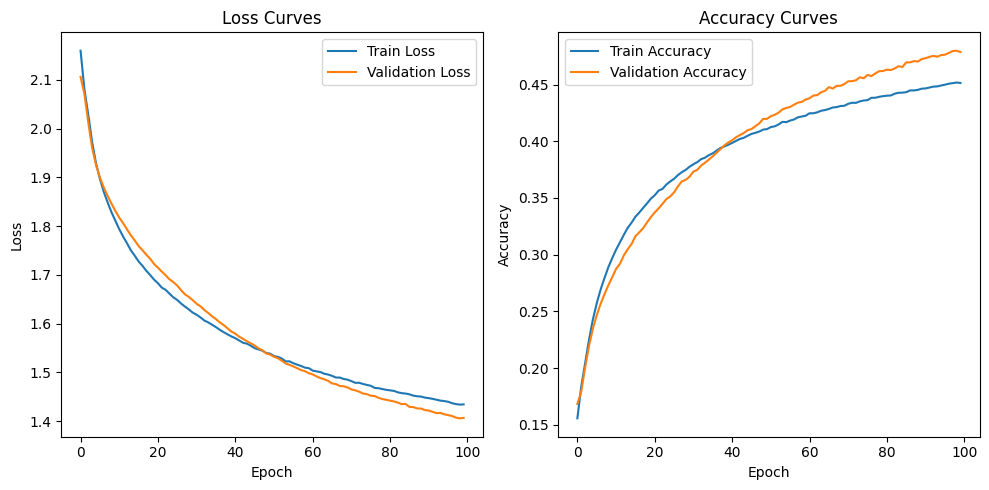

In [12]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(val_set, batch_size=32, shuffle=False)

train_model(model, train_loader, test_loader, 100)

- with 3 Layers - 256,512,1024, dropout=0.2 - 100 epochs - Train accuracy = 45.97 , Test = 50.88
- with 3 Layers - 1024,1024,1024, dropout=0.2 - 100 epochs - Train accuracy = 52.60 , Test = 36.19
- with 3 Layers - 729,729,729 , no dropout , 30 epochs - Train accuracy = 56.98 , Test = 44.27
- with 3 layers - 2124 , 2124 , 2124 , dropout = 0.3 , epochs = 60 , Train = 46.61 , Test = 37.82
- with 3 layers - 256,512,1024 , dropout_rate=0.4  , Epochs = 100 , Train = 33.4 , Test = 47.2
- with 3 layers - 256,512,1024 , No dropout , Epochs = 100 , Train = 0.51 , Test = 0.46
- **with 4 Layers - 256,512,1024,2124 , Dropout=0.2 , Epochs = 200 , Train = 43 , Test = 55.8 , Kaggle = 64.74%**
- with 3 layers - 256,512,1024, dropout=0.2 , Epochs = 50 , Train =33.0 , Test = 44.3

# Fully Connected Network Testing

In [13]:
test_grids = np.load('data/sudoku_test_grids.npy')
test_grids = torch.tensor(test_grids)

In [14]:
def replace_zeros_with_predicted(model, inputs):
    model.eval()
    with torch.no_grad():
        inputs = inputs.to(device, dtype=torch.float)
        inputs = inputs.reshape(1,1,9,9)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.view(-1, 9), 1)
        predicted = predicted+1
        input_sample = inputs.squeeze().cpu().numpy()
        predicted_sample = predicted.cpu().numpy()
        
        input_sample_flat = input_sample.flatten()
        zero_indices = np.where(input_sample_flat == 0)[0]
        input_sample_flat[zero_indices] = predicted_sample[zero_indices]
        modified_inputs = input_sample_flat.reshape(9, 9)

        return modified_inputs

In [15]:
predicted_grids = []

model.eval()
for test_grid in range(len(test_grids)):
    predicted = replace_zeros_with_predicted(model,test_grids[test_grid])
    predicted_grids.append(predicted)

In [16]:
start_time = time.time()
indexes = []
labels= []
for i,j in enumerate(predicted_grids):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(int(preds[row,col]))

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total time taken: {elapsed_time:.2f} seconds")

Total time taken: 1.41 seconds


In [17]:
s =  {"id":indexes , "values":labels}
s = pd.DataFrame(s)
s.to_csv('Submission_ANN.csv', index=False)

# CNN

In [18]:
class SudokuSolverCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(SudokuSolverCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128, kernel_size=3,padding=1)
        self.bn3= nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128,256, kernel_size=3,padding=1)
        self.bn4= nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256,512, kernel_size=3,padding=1)
        self.bn5= nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 256, kernel_size=1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(256 * 9 * 9, 81 * 9)
        self.ln = nn.LayerNorm(81 * 9)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.ln(x)
        return x.view(-1, 9)  

model = SudokuSolverCNN(dropout_rate=0.7)

In [19]:
model.to(device)
model

SudokuSolverCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (dropout): Dropout(p=0.7, inplace=False)
  (fc1): Linear(in_features=20736, out_f

Epoch 1 Validation: 100%|██████████| 157/157 [00:00<00:00, 170.19it/s]


Epoch 1: Train Loss: 1.9558, Train Accuracy: 0.2332, Validation Loss: 1.4915, Validation Accuracy: 0.4661


Epoch 2 Validation: 100%|██████████| 157/157 [00:00<00:00, 174.10it/s]


Epoch 2: Train Loss: 1.2369, Train Accuracy: 0.5829, Validation Loss: 0.8020, Validation Accuracy: 0.7718


Epoch 3 Validation: 100%|██████████| 157/157 [00:00<00:00, 178.15it/s]


Epoch 3: Train Loss: 0.8730, Train Accuracy: 0.7246, Validation Loss: 0.6478, Validation Accuracy: 0.8059


Epoch 4 Validation: 100%|██████████| 157/157 [00:00<00:00, 179.61it/s]


Epoch 4: Train Loss: 0.7505, Train Accuracy: 0.7575, Validation Loss: 0.5851, Validation Accuracy: 0.8128


Epoch 5 Validation: 100%|██████████| 157/157 [00:00<00:00, 177.92it/s]


Epoch 5: Train Loss: 0.6824, Train Accuracy: 0.7736, Validation Loss: 0.5421, Validation Accuracy: 0.8168


Epoch 6 Validation: 100%|██████████| 157/157 [00:00<00:00, 178.24it/s]


Epoch 6: Train Loss: 0.6344, Train Accuracy: 0.7851, Validation Loss: 0.5118, Validation Accuracy: 0.8195


Epoch 7 Validation: 100%|██████████| 157/157 [00:00<00:00, 178.87it/s]


Epoch 7: Train Loss: 0.5972, Train Accuracy: 0.7939, Validation Loss: 0.4904, Validation Accuracy: 0.8205


Epoch 8 Validation: 100%|██████████| 157/157 [00:00<00:00, 177.34it/s]


Epoch 8: Train Loss: 0.5682, Train Accuracy: 0.8008, Validation Loss: 0.4730, Validation Accuracy: 0.8216


Epoch 9 Validation: 100%|██████████| 157/157 [00:00<00:00, 176.93it/s]


Epoch 9: Train Loss: 0.5430, Train Accuracy: 0.8076, Validation Loss: 0.4602, Validation Accuracy: 0.8219


Epoch 10 Validation: 100%|██████████| 157/157 [00:00<00:00, 175.45it/s]


Epoch 10: Train Loss: 0.5223, Train Accuracy: 0.8128, Validation Loss: 0.4490, Validation Accuracy: 0.8227


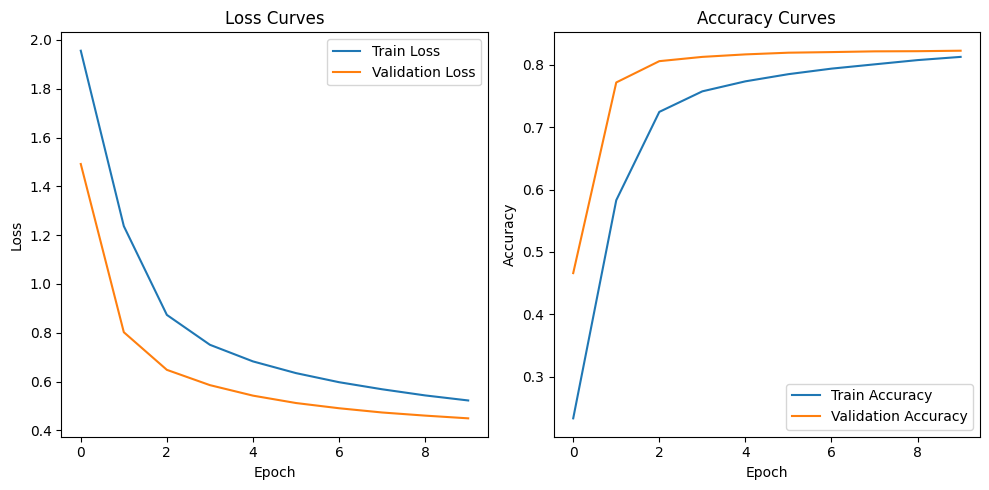

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_set, batch_size=126, shuffle=True)
test_loader = DataLoader(val_set, batch_size=64, shuffle=False)

train_model(model, train_loader, test_loader, 10)

# CNN TEST Predictions


In [21]:
test_grids = np.load('data/sudoku_test_grids.npy')
test_grids = torch.tensor(test_grids)

In [22]:
predicted_grids = []
start_time = time.time()

for test_grid in range(len(test_grids)):
    input_data = test_grids[test_grid].float() 
    input_data = input_data.to(device).reshape(-1,1,9,9)
    outputs = model(input_data)
    _, predicted = torch.max(outputs.view(-1,9),1)
    predicted = predicted.reshape(9,9)+1
    predicted_grids.append(predicted)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total time taken: {elapsed_time:.2f} seconds")

Total time taken: 11.19 seconds


In [23]:
indexes = []
labels= []
for i,j in enumerate(predicted_grids):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(int(preds[row,col]))

In [24]:
s =  {"id":indexes , "values":labels}
s = pd.DataFrame(s)
s.to_csv("Submission_CNN.csv", index=False)

# LSTM

In [25]:
class SudokuSolverLSTM(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(SudokuSolverLSTM, self).__init__()
        self.lstm_input_size = 9 * 9  
        self.hidden_size = 512  
        self.num_layers = 1 
        self.dropout_rate = dropout_rate 
        
        self.lstm = nn.LSTM(self.lstm_input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate) 
        self.fc1 = nn.Linear(self.hidden_size, 81 * 9)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.lstm_input_size)  
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)  
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)  
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)  
        out = self.fc1(out[:, -1, :])  
        return out.view(-1, 9)  

model = SudokuSolverLSTM()

In [26]:
model.to(device)
model

SudokuSolverLSTM(
  (lstm): LSTM(81, 512, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=512, out_features=729, bias=True)
)

Epoch 1 Validation: 100%|██████████| 313/313 [00:00<00:00, 916.41it/s]


Epoch 1: Train Loss: 2.1206, Train Accuracy: 0.1630, Validation Loss: 2.0878, Validation Accuracy: 0.1726


Epoch 2 Validation: 100%|██████████| 313/313 [00:00<00:00, 889.56it/s]


Epoch 2: Train Loss: 2.0820, Train Accuracy: 0.1802, Validation Loss: 2.0793, Validation Accuracy: 0.1756


Epoch 3 Validation: 100%|██████████| 313/313 [00:00<00:00, 882.85it/s]


Epoch 3: Train Loss: 2.0622, Train Accuracy: 0.1904, Validation Loss: 2.0594, Validation Accuracy: 0.1841


Epoch 4 Validation: 100%|██████████| 313/313 [00:00<00:00, 875.43it/s]


Epoch 4: Train Loss: 2.0168, Train Accuracy: 0.2109, Validation Loss: 1.9978, Validation Accuracy: 0.2088


Epoch 5 Validation: 100%|██████████| 313/313 [00:00<00:00, 826.69it/s]


Epoch 5: Train Loss: 1.9435, Train Accuracy: 0.2402, Validation Loss: 1.9173, Validation Accuracy: 0.2393


Epoch 6 Validation: 100%|██████████| 313/313 [00:00<00:00, 901.44it/s]


Epoch 6: Train Loss: 1.8650, Train Accuracy: 0.2696, Validation Loss: 1.8353, Validation Accuracy: 0.2730


Epoch 7 Validation: 100%|██████████| 313/313 [00:00<00:00, 937.67it/s]


Epoch 7: Train Loss: 1.7929, Train Accuracy: 0.2973, Validation Loss: 1.7643, Validation Accuracy: 0.3036


Epoch 8 Validation: 100%|██████████| 313/313 [00:00<00:00, 920.02it/s]


Epoch 8: Train Loss: 1.7320, Train Accuracy: 0.3219, Validation Loss: 1.7020, Validation Accuracy: 0.3298


Epoch 9 Validation: 100%|██████████| 313/313 [00:00<00:00, 912.82it/s]


Epoch 9: Train Loss: 1.6788, Train Accuracy: 0.3444, Validation Loss: 1.6460, Validation Accuracy: 0.3564


Epoch 10 Validation: 100%|██████████| 313/313 [00:00<00:00, 913.24it/s]


Epoch 10: Train Loss: 1.6327, Train Accuracy: 0.3631, Validation Loss: 1.5988, Validation Accuracy: 0.3748


Epoch 11 Validation: 100%|██████████| 313/313 [00:00<00:00, 939.40it/s]


Epoch 11: Train Loss: 1.5937, Train Accuracy: 0.3789, Validation Loss: 1.5563, Validation Accuracy: 0.3947


Epoch 12 Validation: 100%|██████████| 313/313 [00:00<00:00, 872.78it/s]


Epoch 12: Train Loss: 1.5607, Train Accuracy: 0.3921, Validation Loss: 1.5200, Validation Accuracy: 0.4123


Epoch 13 Validation: 100%|██████████| 313/313 [00:00<00:00, 887.31it/s]


Epoch 13: Train Loss: 1.5327, Train Accuracy: 0.4034, Validation Loss: 1.4881, Validation Accuracy: 0.4263


Epoch 14 Validation: 100%|██████████| 313/313 [00:00<00:00, 899.33it/s]


Epoch 14: Train Loss: 1.5070, Train Accuracy: 0.4136, Validation Loss: 1.4599, Validation Accuracy: 0.4382


Epoch 15 Validation: 100%|██████████| 313/313 [00:00<00:00, 889.49it/s]


Epoch 15: Train Loss: 1.4853, Train Accuracy: 0.4224, Validation Loss: 1.4362, Validation Accuracy: 0.4490


Epoch 16 Validation: 100%|██████████| 313/313 [00:00<00:00, 888.38it/s]


Epoch 16: Train Loss: 1.4665, Train Accuracy: 0.4302, Validation Loss: 1.4136, Validation Accuracy: 0.4593


Epoch 17 Validation: 100%|██████████| 313/313 [00:00<00:00, 915.40it/s]


Epoch 17: Train Loss: 1.4498, Train Accuracy: 0.4370, Validation Loss: 1.3945, Validation Accuracy: 0.4674


Epoch 18 Validation: 100%|██████████| 313/313 [00:00<00:00, 894.13it/s]


Epoch 18: Train Loss: 1.4348, Train Accuracy: 0.4428, Validation Loss: 1.3772, Validation Accuracy: 0.4750


Epoch 19 Validation: 100%|██████████| 313/313 [00:00<00:00, 909.08it/s]


Epoch 19: Train Loss: 1.4216, Train Accuracy: 0.4484, Validation Loss: 1.3606, Validation Accuracy: 0.4819


Epoch 20 Validation: 100%|██████████| 313/313 [00:00<00:00, 847.28it/s]


Epoch 20: Train Loss: 1.4085, Train Accuracy: 0.4538, Validation Loss: 1.3459, Validation Accuracy: 0.4883


Epoch 21 Validation: 100%|██████████| 313/313 [00:00<00:00, 923.12it/s]


Epoch 21: Train Loss: 1.3977, Train Accuracy: 0.4578, Validation Loss: 1.3331, Validation Accuracy: 0.4941


Epoch 22 Validation: 100%|██████████| 313/313 [00:00<00:00, 902.61it/s]


Epoch 22: Train Loss: 1.3879, Train Accuracy: 0.4623, Validation Loss: 1.3199, Validation Accuracy: 0.4995


Epoch 23 Validation: 100%|██████████| 313/313 [00:00<00:00, 924.33it/s]


Epoch 23: Train Loss: 1.3776, Train Accuracy: 0.4659, Validation Loss: 1.3087, Validation Accuracy: 0.5049


Epoch 24 Validation: 100%|██████████| 313/313 [00:00<00:00, 892.35it/s]


Epoch 24: Train Loss: 1.3678, Train Accuracy: 0.4704, Validation Loss: 1.2985, Validation Accuracy: 0.5085


Epoch 25 Validation: 100%|██████████| 313/313 [00:00<00:00, 922.26it/s]


Epoch 25: Train Loss: 1.3605, Train Accuracy: 0.4734, Validation Loss: 1.2899, Validation Accuracy: 0.5120


Epoch 26 Validation: 100%|██████████| 313/313 [00:00<00:00, 889.66it/s]


Epoch 26: Train Loss: 1.3530, Train Accuracy: 0.4763, Validation Loss: 1.2798, Validation Accuracy: 0.5167


Epoch 27 Validation: 100%|██████████| 313/313 [00:00<00:00, 920.54it/s]


Epoch 27: Train Loss: 1.3453, Train Accuracy: 0.4795, Validation Loss: 1.2712, Validation Accuracy: 0.5199


Epoch 28 Validation: 100%|██████████| 313/313 [00:00<00:00, 921.45it/s]


Epoch 28: Train Loss: 1.3390, Train Accuracy: 0.4822, Validation Loss: 1.2627, Validation Accuracy: 0.5237


Epoch 29 Validation: 100%|██████████| 313/313 [00:00<00:00, 859.90it/s]


Epoch 29: Train Loss: 1.3321, Train Accuracy: 0.4850, Validation Loss: 1.2555, Validation Accuracy: 0.5276


Epoch 30 Validation: 100%|██████████| 313/313 [00:00<00:00, 923.21it/s]


Epoch 30: Train Loss: 1.3256, Train Accuracy: 0.4880, Validation Loss: 1.2490, Validation Accuracy: 0.5301


Epoch 31 Validation: 100%|██████████| 313/313 [00:00<00:00, 889.58it/s]


Epoch 31: Train Loss: 1.3195, Train Accuracy: 0.4907, Validation Loss: 1.2414, Validation Accuracy: 0.5337


Epoch 32 Validation: 100%|██████████| 313/313 [00:00<00:00, 914.15it/s]


Epoch 32: Train Loss: 1.3141, Train Accuracy: 0.4931, Validation Loss: 1.2343, Validation Accuracy: 0.5370


Epoch 33 Validation: 100%|██████████| 313/313 [00:00<00:00, 922.40it/s]


Epoch 33: Train Loss: 1.3083, Train Accuracy: 0.4958, Validation Loss: 1.2277, Validation Accuracy: 0.5399


Epoch 34 Validation: 100%|██████████| 313/313 [00:00<00:00, 855.54it/s]


Epoch 34: Train Loss: 1.3038, Train Accuracy: 0.4974, Validation Loss: 1.2227, Validation Accuracy: 0.5421


Epoch 35 Validation: 100%|██████████| 313/313 [00:00<00:00, 922.31it/s]


Epoch 35: Train Loss: 1.2983, Train Accuracy: 0.5006, Validation Loss: 1.2167, Validation Accuracy: 0.5448


Epoch 36 Validation: 100%|██████████| 313/313 [00:00<00:00, 899.57it/s]


Epoch 36: Train Loss: 1.2933, Train Accuracy: 0.5019, Validation Loss: 1.2112, Validation Accuracy: 0.5477


Epoch 37 Validation: 100%|██████████| 313/313 [00:00<00:00, 891.40it/s]


Epoch 37: Train Loss: 1.2888, Train Accuracy: 0.5039, Validation Loss: 1.2059, Validation Accuracy: 0.5500


Epoch 38 Validation: 100%|██████████| 313/313 [00:00<00:00, 900.93it/s]


Epoch 38: Train Loss: 1.2842, Train Accuracy: 0.5061, Validation Loss: 1.2005, Validation Accuracy: 0.5531


Epoch 39 Validation: 100%|██████████| 313/313 [00:00<00:00, 916.80it/s]


Epoch 39: Train Loss: 1.2795, Train Accuracy: 0.5083, Validation Loss: 1.1970, Validation Accuracy: 0.5540


Epoch 40 Validation: 100%|██████████| 313/313 [00:00<00:00, 911.25it/s]


Epoch 40: Train Loss: 1.2764, Train Accuracy: 0.5093, Validation Loss: 1.1936, Validation Accuracy: 0.5551


Epoch 41 Validation: 100%|██████████| 313/313 [00:00<00:00, 944.29it/s]


Epoch 41: Train Loss: 1.2723, Train Accuracy: 0.5115, Validation Loss: 1.1881, Validation Accuracy: 0.5583


Epoch 42 Validation: 100%|██████████| 313/313 [00:00<00:00, 859.13it/s]


Epoch 42: Train Loss: 1.2691, Train Accuracy: 0.5123, Validation Loss: 1.1840, Validation Accuracy: 0.5600


Epoch 43 Validation: 100%|██████████| 313/313 [00:00<00:00, 829.47it/s]


Epoch 43: Train Loss: 1.2654, Train Accuracy: 0.5143, Validation Loss: 1.1811, Validation Accuracy: 0.5614


Epoch 44 Validation: 100%|██████████| 313/313 [00:00<00:00, 885.11it/s]


Epoch 44: Train Loss: 1.2621, Train Accuracy: 0.5158, Validation Loss: 1.1783, Validation Accuracy: 0.5625


Epoch 45 Validation: 100%|██████████| 313/313 [00:00<00:00, 881.99it/s]


Epoch 45: Train Loss: 1.2594, Train Accuracy: 0.5167, Validation Loss: 1.1730, Validation Accuracy: 0.5656


Epoch 46 Validation: 100%|██████████| 313/313 [00:00<00:00, 914.20it/s]


Epoch 46: Train Loss: 1.2560, Train Accuracy: 0.5183, Validation Loss: 1.1705, Validation Accuracy: 0.5660


Epoch 47 Validation: 100%|██████████| 313/313 [00:00<00:00, 905.88it/s]


Epoch 47: Train Loss: 1.2536, Train Accuracy: 0.5193, Validation Loss: 1.1675, Validation Accuracy: 0.5678


Epoch 48 Validation: 100%|██████████| 313/313 [00:00<00:00, 894.96it/s]


Epoch 48: Train Loss: 1.2506, Train Accuracy: 0.5209, Validation Loss: 1.1636, Validation Accuracy: 0.5695


Epoch 49 Validation: 100%|██████████| 313/313 [00:00<00:00, 866.46it/s]


Epoch 49: Train Loss: 1.2473, Train Accuracy: 0.5220, Validation Loss: 1.1599, Validation Accuracy: 0.5712


Epoch 50 Validation: 100%|██████████| 313/313 [00:00<00:00, 893.94it/s]


Epoch 50: Train Loss: 1.2446, Train Accuracy: 0.5233, Validation Loss: 1.1583, Validation Accuracy: 0.5718


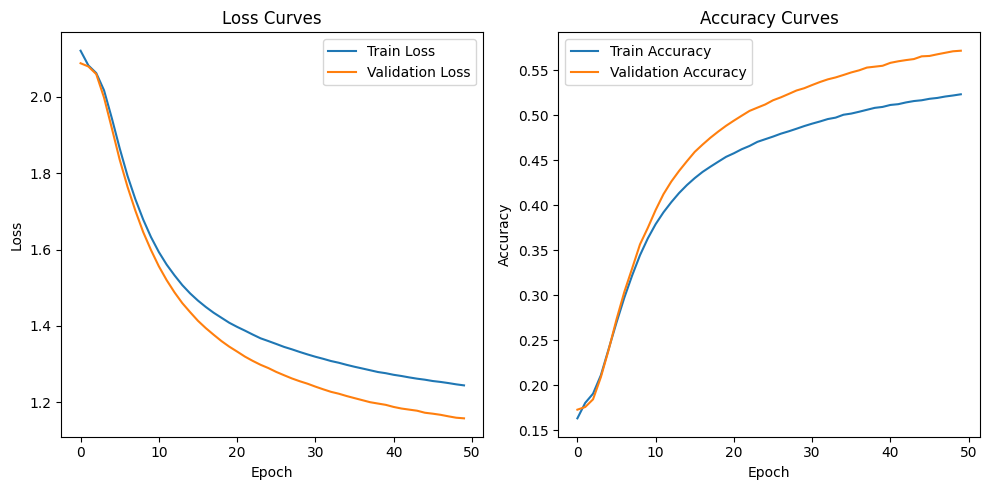

In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(val_set, batch_size=32, shuffle=False)
                         
train_model(model, train_loader, test_loader, 50)

LSTM Experimentation

- 1024 neurons , 1 layer , 50 epochs , Dropout = 0.1 , Training = 63.55 , testing = 55.83
- **1024 neurons , 1 layer , 50 epochs , Dropout = 0.4 , Training =  50.83 , testing = 58.49**
- 1024 neurons , 1 layer , 50 epochs , Dropout = 0.2 , Training =  59.51  , testing = 57.91
- 1024 neurons , 1 layer , 100 epochs , Dropout = 0.2 , Training =  62.22 , testing = 59.82
- 1024 neurons , 2 layer , 50 epochs , Dropout = 0.2 , Training =  74.27 , testing = 41.09
- 1024 neurons , 2 layer , 50 epochs , Dropout = 0.4 , Training =  62.44 , testing = 42.17
- 512 neurons , 1 layer , 50 epochs , Dropout = None , Training =  63.50, Testing = 55.85
- 512 neurons , 1 layer , 50 epochs , Dropout = 0.2 , Training =  51.97, Testing = 56.71

# LSTM Testing

In [28]:
predicted_grids = []

model.eval()
for test_grid in range(len(test_grids)):
    predicted = replace_zeros_with_predicted(model,test_grids[test_grid])
    predicted_grids.append(predicted)

In [29]:
start_time = time.time()
indexes = []
labels= []
for i,j in enumerate(predicted_grids):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(int(preds[row,col]))

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total time taken: {elapsed_time:.2f} seconds")

Total time taken: 1.42 seconds


In [30]:
s =  {"id":indexes , "values":labels}
s = pd.DataFrame(s)
s.to_csv("Submission_LSTM.csv", index=False)

# CNN + LSTM

In [31]:
class SudokuSolverCNNLSTM(nn.Module):
    def __init__(self):
        super(SudokuSolverCNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 512, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 512, kernel_size=1)
        self.lstm_input_size = 512  
        self.hidden_size = 512  
        self.num_layers = 1  
        self.lstm = nn.LSTM(self.lstm_input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  
        self.fc1 = nn.Linear(self.hidden_size, 81 * 9)

    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = x.view(batch_size, -1, self.lstm_input_size)  
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)  
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)  
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)  
        out = self.fc1(out[:, -1, :]) 
        return out.view(-1, 9)  

model = SudokuSolverCNNLSTM()

In [32]:
model.to(device)
model

SudokuSolverCNNLSTM(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
  (lstm): LSTM(512, 512, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=512, out_features=729, bias=True)
)

Epoch 1 Validation: 100%|██████████| 157/157 [00:01<00:00, 127.56it/s]


Epoch 1: Train Loss: 1.9881, Train Accuracy: 0.2004, Validation Loss: 1.8362, Validation Accuracy: 0.2538


Epoch 2 Validation: 100%|██████████| 157/157 [00:01<00:00, 131.28it/s]


Epoch 2: Train Loss: 1.7198, Train Accuracy: 0.3234, Validation Loss: 1.5811, Validation Accuracy: 0.3972


Epoch 3 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.54it/s]


Epoch 3: Train Loss: 1.5342, Train Accuracy: 0.4241, Validation Loss: 1.4378, Validation Accuracy: 0.4785


Epoch 4 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.37it/s]


Epoch 4: Train Loss: 1.4094, Train Accuracy: 0.4878, Validation Loss: 1.3289, Validation Accuracy: 0.5260


Epoch 5 Validation: 100%|██████████| 157/157 [00:01<00:00, 134.07it/s]


Epoch 5: Train Loss: 1.3150, Train Accuracy: 0.5299, Validation Loss: 1.2485, Validation Accuracy: 0.5595


Epoch 6 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.40it/s]


Epoch 6: Train Loss: 1.2504, Train Accuracy: 0.5568, Validation Loss: 1.1969, Validation Accuracy: 0.5810


Epoch 7 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.33it/s]


Epoch 7: Train Loss: 1.2019, Train Accuracy: 0.5761, Validation Loss: 1.1609, Validation Accuracy: 0.5936


Epoch 8 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.18it/s]


Epoch 8: Train Loss: 1.1623, Train Accuracy: 0.5913, Validation Loss: 1.1303, Validation Accuracy: 0.6035


Epoch 9 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.81it/s]


Epoch 9: Train Loss: 1.1304, Train Accuracy: 0.6034, Validation Loss: 1.1127, Validation Accuracy: 0.6087


Epoch 10 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.94it/s]


Epoch 10: Train Loss: 1.1013, Train Accuracy: 0.6134, Validation Loss: 1.0949, Validation Accuracy: 0.6153


Epoch 11 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.50it/s]


Epoch 11: Train Loss: 1.0752, Train Accuracy: 0.6224, Validation Loss: 1.0833, Validation Accuracy: 0.6190


Epoch 12 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.28it/s]


Epoch 12: Train Loss: 1.0508, Train Accuracy: 0.6309, Validation Loss: 1.0752, Validation Accuracy: 0.6209


Epoch 13 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.61it/s]


Epoch 13: Train Loss: 1.0276, Train Accuracy: 0.6381, Validation Loss: 1.0740, Validation Accuracy: 0.6211


Epoch 14 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.34it/s]


Epoch 14: Train Loss: 1.0051, Train Accuracy: 0.6456, Validation Loss: 1.0738, Validation Accuracy: 0.6220


Epoch 15 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.32it/s]


Epoch 15: Train Loss: 0.9845, Train Accuracy: 0.6523, Validation Loss: 1.0763, Validation Accuracy: 0.6206


Epoch 16 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.56it/s]


Epoch 16: Train Loss: 0.9659, Train Accuracy: 0.6585, Validation Loss: 1.0817, Validation Accuracy: 0.6207


Epoch 17 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.65it/s]


Epoch 17: Train Loss: 0.9478, Train Accuracy: 0.6643, Validation Loss: 1.0813, Validation Accuracy: 0.6212


Epoch 18 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.51it/s]


Epoch 18: Train Loss: 0.9315, Train Accuracy: 0.6697, Validation Loss: 1.0891, Validation Accuracy: 0.6195


Epoch 19 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.45it/s]


Epoch 19: Train Loss: 0.9152, Train Accuracy: 0.6750, Validation Loss: 1.0920, Validation Accuracy: 0.6193


Epoch 20 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.80it/s]


Epoch 20: Train Loss: 0.9011, Train Accuracy: 0.6796, Validation Loss: 1.0962, Validation Accuracy: 0.6191


Epoch 21 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.08it/s]


Epoch 21: Train Loss: 0.8876, Train Accuracy: 0.6840, Validation Loss: 1.1061, Validation Accuracy: 0.6174


Epoch 22 Validation: 100%|██████████| 157/157 [00:01<00:00, 130.29it/s]


Epoch 22: Train Loss: 0.8753, Train Accuracy: 0.6882, Validation Loss: 1.1125, Validation Accuracy: 0.6160


Epoch 23 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.28it/s]


Epoch 23: Train Loss: 0.8628, Train Accuracy: 0.6921, Validation Loss: 1.1192, Validation Accuracy: 0.6155


Epoch 24 Validation: 100%|██████████| 157/157 [00:01<00:00, 132.60it/s]


Epoch 24: Train Loss: 0.8509, Train Accuracy: 0.6961, Validation Loss: 1.1239, Validation Accuracy: 0.6141


Epoch 25 Validation: 100%|██████████| 157/157 [00:01<00:00, 133.15it/s]


Epoch 25: Train Loss: 0.8409, Train Accuracy: 0.6996, Validation Loss: 1.1326, Validation Accuracy: 0.6139


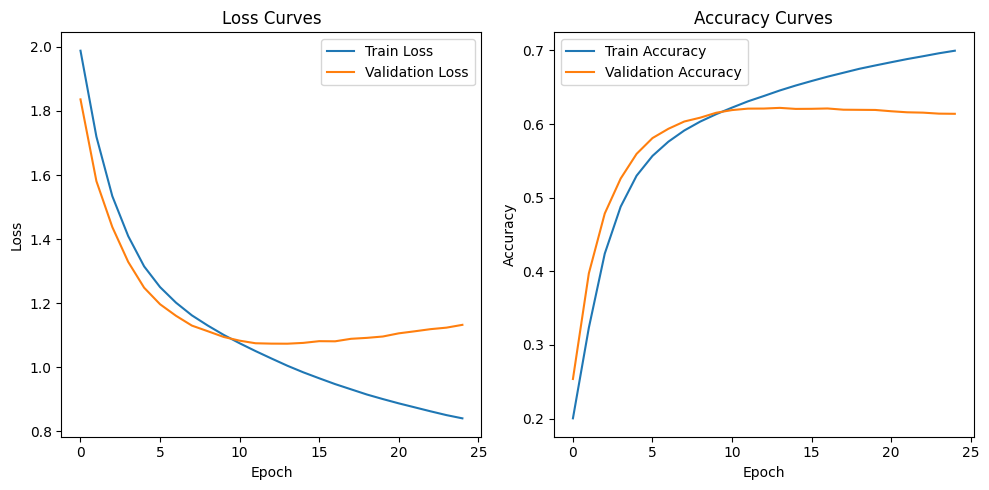

In [33]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_set, batch_size=126, shuffle=True)
test_loader = DataLoader(val_set, batch_size=64, shuffle=False)

train_model(model, train_loader, test_loader, 25)

# CNN + LSTM Testing

In [34]:
predicted_grids = []

model.eval()
for test_grid in range(len(test_grids)):
    predicted = replace_zeros_with_predicted(model,test_grids[test_grid])
    predicted_grids.append(predicted)

In [35]:
start_time = time.time()
indexes = []
labels= []
for i,j in enumerate(predicted_grids):
    preds = j.reshape(9,9)
    for row in range(0,9):
        for col in range(0,9):
            index = str(i)+"_"+str(row)+str(col)
            indexes.append(index)
            labels.append(int(preds[row,col]))

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total time taken: {elapsed_time:.2f} seconds")

Total time taken: 1.41 seconds


In [36]:
s =  {"id":indexes , "values":labels}
s = pd.DataFrame(s)
s.to_csv('Submission_CNNLSTM.csv', index=False)

# Overall Results

Kaggle Accuracy:

Fully Connected Network : 62.1

Convolutional Neural Network : 83.6

LSTM -  61

CNN + LSTM  -  64 

